Note: Some of the code in this notebook can be made more efficient if needed by using functions included in numpy instead of using loops, etc.

Set parent directroy to recursively search for mat files

In [ ]:
read_dir = 'example_dir/uncategorized scans'
output_dir = "example_dir/scans"
class_map_loc = "example_dir/tumorgradeonly.csv"

# Imports

In [ ]:
import scipy.io
import os
from PIL import Image
import numpy as np
!pip install mat73
import mat73

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Mat --> Image Mapping

In [ ]:
def generate_map():
  with open(class_map_loc, "r", encoding="utf-8") as f:
    contents = f.read().split("\n")
  contents = [x.split(",") for x in contents][1:]
  contents = [[z if z!="" else None for z in x] for x in contents]
  global grade_map
  grade_map = {int(c[0]): {"High Grade": int(c[2]) if c[2] != None else None, "f grade":int(c[1]) if c[1] != None else None} for c in contents}
  return grade_map
generate_map()

{1: {'High Grade': 0, 'f grade': 2},
 2: {'High Grade': 1, 'f grade': 3},
 3: {'High Grade': 0, 'f grade': 2},
 4: {'High Grade': 1, 'f grade': 3},
 5: {'High Grade': 0, 'f grade': 2},
 6: {'High Grade': 0, 'f grade': 2},
 7: {'High Grade': 1, 'f grade': 3},
 8: {'High Grade': 0, 'f grade': 2},
 9: {'High Grade': 0, 'f grade': 2},
 10: {'High Grade': 1, 'f grade': 3},
 11: {'High Grade': 0, 'f grade': 2},
 12: {'High Grade': 1, 'f grade': 3},
 13: {'High Grade': 1, 'f grade': 3},
 14: {'High Grade': 1, 'f grade': 4},
 15: {'High Grade': 1, 'f grade': 4},
 16: {'High Grade': 1, 'f grade': 3},
 17: {'High Grade': 1, 'f grade': 4},
 18: {'High Grade': None, 'f grade': None},
 19: {'High Grade': 1, 'f grade': 3},
 20: {'High Grade': 0, 'f grade': 2},
 21: {'High Grade': 1, 'f grade': 3},
 22: {'High Grade': 0, 'f grade': 2},
 23: {'High Grade': 1, 'f grade': 3},
 24: {'High Grade': 0, 'f grade': 2},
 25: {'High Grade': 0, 'f grade': 2},
 26: {'High Grade': 1, 'f grade': 4},
 27: {'High Gra

In [ ]:
def scan_path_to_scan_num(scan_path):
  # Assumes last folder is the name of the scan
  folder_name = os.path.basename(os.path.dirname(scan_path))
  scan_num = int(folder_name.replace("RCCPV", ""))
  return scan_num

# .mat loading and image saving code


In [ ]:
# https://stackoverflow.com/questions/22902040/convert-black-and-white-array-into-an-image-in-python
def img_conversion(mat_array, output_dir, filename="MISSING SCAN NUM", strategy="largest"):
  """Saves the loaded .mat array (numpy array) to an image at output_dir with
     given filename

     Parameters
     ----------
      mat_array: numpy.ndarray
        The array representing the segmented scan read from the .mat file

      output_dir: str
        The directory where the image will be saved to

      filename: str, optional
        Name of the file to be saved in the output directory

      strategy: str, optional
        The strategy for which slice of a scan is output as an image

        largest (default):
          Outputs the slice of the scan with the most non-zero values

        largest2 :
          Outputs the slice of the scan with the most and second largest non-zero values

        all
          Outputs all slices of the scan as an image
        first
          Outputs the first slice of the scan that contains a non-zero value
        middle
          Outputs the middle slice of the scan within the range of slices that
          contain non-zero values in each slice
        last
          Outputs the last slice of the scan that contains a non-zero value
        fml
          Outputs the first, middle, and last slice of the scan that contains a
          non-zero value

  """
  nons = []
  for i in range(mat_array.shape[-1]):
    m = mat_array[:,:,i]
    im = m.astype('uint8')*255
    if strategy == "all":
      img = Image.fromarray(im)
      img.save(os.path.join(output_dir, f"{filename}-{str(i)}.jpg"))
    else:
      nons.append(np.count_nonzero(im))

  if strategy == "all":
    return

  # This can be cleaned up a bit
  elif strategy == "largest":
    m = nons.index(max(nons))

  elif strategy == "first":
    m = [i for i,x in enumerate(nons) if x!=0][0]

  elif strategy == "middle":
    n = [i for i,x in enumerate(nons) if x!=0]
    f = n[0]
    l = n[-1]
    m = (l-f+1)//2

  elif strategy == "last":
    m = [i for i,x in enumerate(nons) if x!=0][-1]

  elif strategy == "fml":
    n = [i for i,x in enumerate(nons) if x!=0]
    f = n[0]
    l = n[-1]
    mid = (l-f+1)//2

    m = [f, mid, l]

  else:
    print(f"Error, no such strategy as {strategy}")
    return

  if type(m) == int:
    img = Image.fromarray(mat_array[:,:,m].astype('uint8')*255)
    print(f"Saved at {os.path.join(output_dir, filename+'.jpg')}")
    img.save(os.path.join(output_dir, filename+".jpg"))
  else:
    for i, x in enumerate(m):
      img = Image.fromarray(mat_array[:,:,x].astype('uint8')*255)
      print(f"Saved at {os.path.join(output_dir, f'{filename}-{str(i)}.jpg')}")
      img.save(os.path.join(output_dir, f"{filename}-{str(i)}.jpg"))

In [ ]:
def retrieve_mat(mat_file_loc, output_dir, categorize_by_high_grade=True, generalize=False):
  """Extracts a scan for the given matlab file

      Additionally, this function calls img_conversion to create an image file

    Parameters
    ----------
      mat_file_loc: str
        File path of the matlab file for which the scan will be retrieved

      output_dir: str
        The parent directory where the images will be saved. The images will be
        saved in subfolders corresponding to their class. The class of the image
        is determined based on the mapping file. Images without a corresponding
        class in the mapping folder will be skipped

      generalize: bool, optional
        When set to True, it will attempt to extract the scan using the first key
        it finds that doesn't follow the format: "__example__" (double underscores
        generally specify something that is meant to be private)

        When set to False (default behavior), the code will use "segmented tumor"
        as the default key to access the scan

  """

  ##### Prepare output loc
  # get mapping of the current scan
  # make folder based on class from mapping
  # pass correct variables into function call


  scan_num = scan_path_to_scan_num(mat_file_loc)

  if categorize_by_high_grade:
    scan_class_num = grade_map[scan_num]["High Grade"]
    if scan_class_num == 1:
      scan_class = "high"
    elif scan_class_num == 0:
      scan_class = "low"
    else:
      return

  else:
    scan_class_num = grade_map[scan_class_num]["f grade"]
    if scan_class_num == None:
      return
    else:
      scan_class = str(scan_class_num)

  output_dir = os.path.join(output_dir,scan_class)
  if not os.path.exists(output_dir):
    os.makedirs(output_dir)


  # Actually retrieve the scan from the .mat file

  key = "segmented_tumor"

  if generalize:
    mat = scipy.io.loadmat(mat_file_loc)
    keys = [x for x in list(mat.keys()) if not x.endswith("__") and not x.startswith("__")]
    if len(keys) > 1:
      print("Multiple keys, choosing first key")
    key = keys[0]

  try:
    mat = scipy.io.loadmat(mat_file_loc)
  except NotImplementedError as e:
    # This error indicates that the matlab file is a type not supported by our
    # library. Check the link below if you need to implement this
    # https://stackoverflow.com/questions/17316880/reading-v-7-3-mat-file-in-python
    print(f"COULD NOT ACCESS {mat_file_loc}. ERROR: {e}")
    return

  img_conversion(mat[key], output_dir, filename=str(scan_num))

In [ ]:
def traverse(current_directory, base_output_directory, file_suffix_to_traverse="segmented_tumor.mat"):
  """
    Recursively traverse the given directory and create an image for each given
    scan at the supplied output directory

    Parameters
    ----------

    current_directory: str
      The directory of which subdirectories will be searched and images will be
      created from found matlab files

    output_directory: str
      The directory where jpg images will be created in a folder corresponding
      to their class

    file_suffix_to_traverse: str or NoneType
      A string to specify what file suffix to look for. If None, then the
      function will load any .mat file
  """
  dirs = os.listdir(current_directory)

  for dir in dirs:
    p = os.path.join(current_directory, dir)
    if os.path.isdir(p):
      print(dir)
      traverse(p, base_output_directory)
    elif (file_suffix_to_traverse == None and p.endswith(".mat")) or p.endswith(file_suffix_to_traverse):
      retrieve_mat(p, output_dir)
traverse(read_dir, output_dir)

# Experiments

Below you will find code fragments from different things that I was working on or found useful

(512, 512, 63)
Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.8/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['mat']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


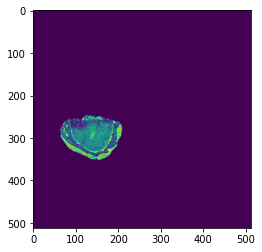

In [ ]:
# This finally allowed me to figure out how to use the correct dimension to slice the scans

p = "/example_dir/uncategorized scans/RCCPVXXX/segmented_tumor.mat"
mat= scipy.io.loadmat(p)
og = mat["segmented_tumor"]
print(og.shape)
# rot = np.rot90(og())
# rot = og

nons = []

# for i,m in enumerate(og.shape[-1]):
for i in range(og.shape[-1]):
    m = og[:,:,i]
    im = m.astype('uint8')*255
    nons.append(np.count_nonzero(im))


m = nons.index(max(nons))

img = og[:,:,m].astype('uint8')*255

# https://stackoverflow.com/questions/35286540/display-an-image-with-python
%pylab inline
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
# Show segmented image
imgplot = plt.imshow(img)
plt.show()

In [ ]:
# l = os.listdir("example_dir/scans/train/high/")
# # print(l)
# print(os.path.isdir("example_dir/scans/train/high/"))
# [os.path.isdir(x) for x in l]
# list(os.walk(dataset_parent_dir, False))

mat = scipy.io.loadmat("/example_dir/scans/train/high/RCCPVXXX/segmented_tumor.mat")

In [ ]:
# type(mat)
# len(mat)
print(mat.keys())
# print(mat["__header__"])
print(mat["segmented_tumor"][0].shape)

dict_keys(['__header__', '__version__', '__globals__', 'segmented_tumor'])
(512, 375)


In [ ]:
keys = [x for x in list(mat.keys()) if not x.endswith("__") and not x.startswith("__")]
keys

['segmented_tumor']

In [ ]:
keys = [x for x in list(mat.keys()) if not x.endswith("__") and not x.startswith("__")]
key = keys[0]
nons = []
for i in range(mat[key].shape[0]):
  im = mat["segmented_tumor"][i].astype('uint8')*255
  # print(f"i: {i}, Non-zero: {np.count_nonzero(im)}")
  nons.append(np.count_nonzero(im))
m = nons.index(max(nons))
im = mat["segmented_tumor"][m].astype('uint8')*255

In [ ]:
img = Image.fromarray(im)